In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skradar

# Radar Settings
Here we define some important settings like bandwidth, number of fast- and slow-time samples etc. We assume a continuous-wave radar without any gaps. Therefore, the slow-time sampling rate can be derived from the fast-time settings.

In [2]:
B = 1e9
fc = 76.5e9
N_f = 512  # number of fast-time samples
fs_f = 1e6  # fast-time sampling rate
Ts_s = (N_f-1)/fs_f  # slow-time sampling interval
N_s = 1  # number of slow-time samples

Next we define the positions of transmit (TX) and receive (RX) antennas in the local coordinate system of the radar. In this example both TX and RX are placed at the local origin.

In [3]:
tx_pos = np.array([[0], [0], [0]])
rx_pos = np.array([[0], [0], [0]])

Now we can place a virtual radar at the origin of the world coordinate system

In [4]:
radar_pos = np.array([[0], [0], [0]])
radar = skradar.FMCWRadar(B=B, fc=fc, N_f=N_f, T_f=1/fs_f, T_s=Ts_s,
                    N_s=N_s, tx_pos=tx_pos, rx_pos=rx_pos,
                    pos=radar_pos, name='First radar')

# Target Placement, Scene Configuration, and Visualization
Place a target at a distance of 10 m in y-direction

In [5]:
target_pos = np.array([[0], [11.3], [0]])
target = skradar.Target(rcs=1, pos=target_pos, name='Static target, 1 sqm')

Configure the scene which consists of radar and target and visualize it. The visualization is plotted in the world coordinate system, therefore radar and world coordinates overlap.

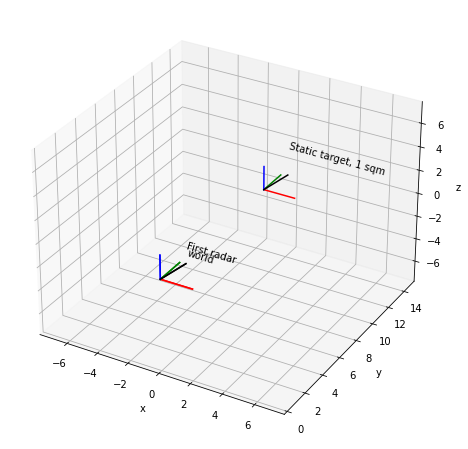

In [6]:
scene = skradar.Scene([radar], [target])

fig = plt.figure(1, figsize=(12,8))
plt.clf()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim((-7.5, 7.5))
ax.set_ylim((0, 15))
ax.set_zlim((-7.5, 7.5))
scene.visualize('world', ax, coord_len=2)

Note that it would also be possible to visualize the scene in other coordinate systems. The following plot shows the scene in the coordinate system of the target.

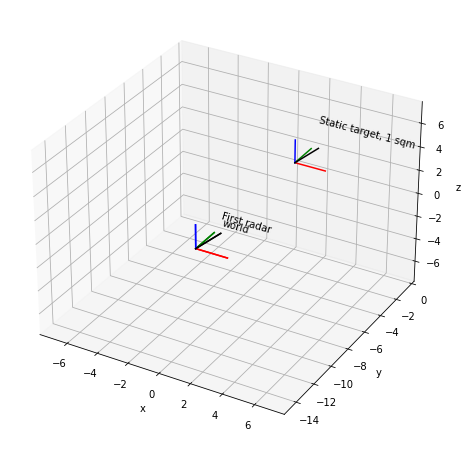

In [7]:
fig = plt.figure(2, figsize=(12,8))
plt.clf()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim((-7.5, 7.5))
ax.set_ylim((-15, 0))
ax.set_zlim((-7.5, 7.5))
scene.visualize(target, ax, coord_len=2)

# Radar Signal Simulation and Range Processing
The function ```sim_chirps``` automatically calculates all distances between the targets in the scene and all TX- and RX-antennas. Here ```radar``` is an ```FMCWRadar``` object; therefore the results are the dechirped signals for each TX-RX combination.

In [8]:
radar.sim_chirps()

Now it is possible to perform range compression on the FMCW IF signal which is realized within the ```range_compression``` function.

In [9]:
radar.range_compression(zp_fact=128)

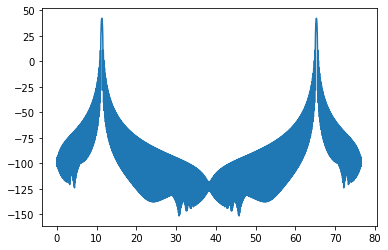

In [10]:
plt.figure(2)
plt.clf()    
plt.plot(radar.ranges/2, 20*np.log10(np.abs(radar.rp[0,0,0,:])));

In [11]:
peak_idx = np.argmax(np.abs(radar.rp[0,0,0,:len(radar.ranges)//2]))
print(f'Estimated target distance: {radar.ranges[peak_idx]/2:.3f} m')

Estimated target distance: 11.300 m
